## Aufgabe 6: Machine Learning for NLP - Überblick
Unsere heutige Übung soll einen ersten, groben Überblick über Machine Learning bieten.
Für Machine Learning gibt es umfassende Unterstützung wie z. B. [scikit-learn](https://scikit-learn.org/stable/getting_started.html). 

Zunächst starten wir mit einer Exkursion zum Thema *Bag-of-Words* bevor wir detaillierter den Ablauf einer Klassifikation angehen. 

#### Benötigte Module

In [11]:
import string 
import re

import spacy
import nltk
from nltk.corpus import stopwords

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### Exkursion: Bag-of-Words
#### Vokabular
Wir starten zunächst mit einem kleinen Beispiel, um die Grundlagen besser zu verstehen. 
Die drei Sätze in der List *texts* entsprechen unseren Dokumenten und bilden gemeinsam das gesamte Korpus. 
Insgesamt enthalten die drei Sätze 12 verschiedenen Wörter. 
Somit haben wir 12 verschiedene Wörter in unserem gesamten Korpus, woraus wiederum folgt, dass das Vokabular 12 Wörter enthält. 
Nach der Transformierung wird jedes Dokument durch einen Vektor der Größe 12 dargestellt.

In [12]:
texts = [
    "blue car and blue window",
    "black crow in the window",
    "i see my reflection in the window"
]

In [13]:
# Vocabulary
vocab = sorted(set(word for sentence in texts for word in sentence.split()))
print(len(vocab), vocab)

12 ['and', 'black', 'blue', 'car', 'crow', 'i', 'in', 'my', 'reflection', 'see', 'the', 'window']


##### Binärmatrix
Mit dem [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) und der Option 'binary=True' wird eine Binärmatrix erstellt.

In [14]:
# create CountVectorizer
bin_vec = CountVectorizer(binary=True)
# fit vectorizer on data
bin_vec.fit(texts)

print([w for w in sorted(bin_vec.vocabulary_.keys())])

['and', 'black', 'blue', 'car', 'crow', 'in', 'my', 'reflection', 'see', 'the', 'window']


Das Vokabular kann in einen [pandas-DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) eingelesen und dargestellt werden.

In [15]:
pd.DataFrame(bin_vec.transform(texts).toarray(), columns=sorted(bin_vec.vocabulary_.keys()))

,and,black,blue,car,crow,in,my,reflection,see,the,window
0,1,0,1,1,0,0,0,0,0,0,1
1,0,1,0,0,1,1,0,0,0,1,1
2,0,0,0,0,0,1,1,1,1,1,1


##### Frequenzmatrix
Setzt man die Option 'binary' nicht auf True, dann erstellt der [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) eine Frequenzmatrix.

In [16]:
cnt_vec = CountVectorizer()
cnt_vec.fit(texts)

pd.DataFrame(cnt_vec.transform(texts).toarray(), columns=sorted(cnt_vec.vocabulary_.keys()))

,and,black,blue,car,crow,in,my,reflection,see,the,window
0,1,0,2,1,0,0,0,0,0,0,1
1,0,1,0,0,1,1,0,0,0,1,1
2,0,0,0,0,0,1,1,1,1,1,1


#### tf-idf-Matrix
Der [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) erstellt eine Matrix basierend auf tf-idf.

In [17]:
tfidf_vec = TfidfVectorizer()
tfidf_vec.fit(texts)

pd.DataFrame(tfidf_vec.transform(texts).toarray(), columns=sorted(tfidf_vec.vocabulary_.keys()))

,and,black,blue,car,crow,in,my,reflection,see,the,window
0,0.396875,0.000000,0.793749,0.396875,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.234400
1,0.000000,0.534093,0.000000,0.000000,0.534093,0.406192,0.00000,0.00000,0.00000,0.406192,0.315444
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.358291,0.47111,0.47111,0.47111,0.358291,0.278245


### a) Ablauf einer Klassifikation 
Den Use Case nehmen wir aus der NLP-Anwendung *Sentiment Analysis*. Die Datei *wine_reviews.csv.txt* enthält Rezensionen sowie ein Rating (terrific | horrible) zu Weinen. Wir werden ein Modell trainieren, das uns voraussagt, ob eine Rezension *terrific* oder *horrible* ist.

1. Preprocessing
2. Feature Extraction
3. *k*-fold Cross Validation
4. Hyperparameter-Tuning


#### 1. Preprocessing Pipeline
Wie in der Vorlesung erläutert, sollten die Daten vor Machine Learning-Anwendungen bereinigt werden. Basierend auf unserem Use Case *Sentiment Analysis* führen wir folgende Preprocessing-Schritte aus:

- Kontraktionen expandieren (wegen Negationen)
- Tokenization & Lemmatization 
- Stopwords entfernen (außer Negationen)
- Satzzeichen entfernen

##### 1.1 spaCy-Modell, Stoppwort-Liste und Satzzeichen-Liste

In [18]:
# English spacy model
nlp = spacy.load("en_core_web_sm")
# Stop word list from NLTK
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')
# Punctuation list from string
puncts = string.punctuation


##### 1.2 Kontraktionen expandieren

In [19]:
# Kontraktionen exandieren -> Negation
def decontract_phrase(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"shan\'t", "shall not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not ", phrase)
    phrase = re.sub(r"\'re ", " are ", phrase)
    phrase = re.sub(r"\'s ", " is ", phrase)
    phrase = re.sub(r"\'d ", " would ", phrase)
    phrase = re.sub(r"\'ll ", " will ", phrase)
    phrase = re.sub(r"\'t ", " not ", phrase)
    phrase = re.sub(r"\'ve ", " have ", phrase)
    phrase = re.sub(r"\'m ", " am ", phrase)
    
    phrase = re.sub(r'\s+', ' ', phrase)

    return phrase

##### 1.3 Tokenisierung und Lemmatisierung

In [20]:
def get_lemma(review):
    doc = nlp(review)
    lemma_text = ' '.join([token.lemma_ for token in doc])
    
    return lemma_text


##### 1.4 Preprocessing Pipeline

In [21]:
def preprocess_pipeline(review):
    # Kontraktionen expandieren
    review = decontract_phrase(review)
    # Tokenisierung und Lemmatisierung
    review = get_lemma(review)    
    # Stopwords
    review = ' '.join([token for token in review.split() if token.lower() not in stopword_list])
    # Satzzeichen
    review = ''.join([character for character in review if character not in puncts])
    # Remove multiple whitespaces
    review = re.sub(r'^\s+', '', review)
    review = re.sub(r' +', ' ', review)
    review = re.sub(r'\s+$', '', review)
    
    return review

test = "This wine isn't like other wines."
preprocess_pipeline(test)

'wine not like wine'

##### 1.5 Datei mittels pandas einlesen

In [22]:
dataset = pd.read_csv('./wine_reviews.csv.txt')
dataset.head()

,Review,Rating
0,"Liquorice, cherry fruit. Simple and coarse at ...",horrible
1,Thin and completely uninspiring.,horrible
2,"Charming, violet-fragranced nose. Classic Guig...",terrific
3,Good grip and a touch of rusticity on the leng...,terrific
4,"Gummy nose, merlot-style sweetness. Good wine,...",terrific


In [23]:
# Are all columns defined?
# Non-Null Count shows how many rows for each column are well-defined
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532 entries, 0 to 531
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  532 non-null    object
 1   Rating  532 non-null    object
dtypes: object(2)
memory usage: 8.4+ KB


##### 1.6 Preprocessing anwenden
Preprocessing auf Spalte 'Review' anwenden und Ergebnis in einer neuen Spalte 'Preprocessed' im DataFrame  speichern.


In [24]:
dataset['Preprocessed'] = dataset['Review'].apply(preprocess_pipeline)


In [25]:
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532 entries, 0 to 531
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Review        532 non-null    object
 1   Rating        532 non-null    object
 2   Preprocessed  532 non-null    object
dtypes: object(3)
memory usage: 12.6+ KB


#### 2. Feature Extraction

##### 2.1 Features
Wir erstellen für unsere Reviews eine Frequenzmatrix auf Basis von Unigrammen mit Hilfe des [CountVectorizers](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). 

**Hinweis:** 
- Vectorizer werden ausschließlich auf Text angewendet
- Als Ergebnis erhält man Features
- Diese Features entsprechen X



In [26]:
# word level CountVectorizer
cnt_vec = CountVectorizer()
X_cnt = cnt_vec.fit_transform(dataset['Preprocessed'])
print(X_cnt)


  (0, 787)	1
  (0, 263)	1
  (0, 573)	1
  (0, 1204)	1
  (0, 293)	1
  (0, 527)	1
  (1, 1347)	1
  (1, 311)	1
  (1, 1417)	1
  (2, 256)	1
  (2, 1456)	1
  (2, 560)	1
  (2, 896)	1
  (2, 281)	1
  (2, 636)	1
  (2, 338)	1
  (2, 1138)	1
  (3, 612)	1
  (3, 631)	1
  (3, 1375)	1
  (3, 1149)	1
  (3, 776)	1
  (3, 1432)	1
  (3, 1192)	1
  (3, 411)	1
  :	:
  (530, 1192)	1
  (530, 897)	1
  (530, 844)	1
  (530, 1122)	1
  (530, 979)	1
  (530, 130)	1
  (530, 1260)	1
  (530, 789)	1
  (530, 1357)	1
  (530, 656)	1
  (530, 688)	1
  (531, 612)	1
  (531, 897)	1
  (531, 1033)	1
  (531, 1373)	1
  (531, 1122)	1
  (531, 1453)	1
  (531, 1454)	1
  (531, 170)	1
  (531, 715)	1
  (531, 346)	1
  (531, 604)	1
  (531, 463)	1
  (531, 389)	1
  (531, 111)	1


In [27]:
print(X_cnt.shape)


(532, 1507)


##### 2.2 Linguistic Features
Zusätzlich zu den oben erstellten Features können wir z. B. zusätzlich linguistische Features nutzen. Diese müssen aber normalisiert werden (siehe Vorlesung). 

In [28]:
dataset['char_count'] = dataset['Review'].apply(len)
dataset['word_count'] = dataset['Review'].apply(lambda x: len(x.split()))
dataset['Density'] = dataset['char_count'] / (dataset['word_count']+1)
dataset['punctuation_count'] = dataset['Review'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation)))
dataset['Punct_Count_Ratio'] = dataset['punctuation_count'] / dataset['word_count']

# Beispiele für andere linguistische Feature
#dataset['title_word_count'] = dataset['Review'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
#dataset['upper_case_word_count'] = dataset['Review'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))


In [29]:
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532 entries, 0 to 531
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Review             532 non-null    object 
 1   Rating             532 non-null    object 
 2   Preprocessed       532 non-null    object 
 3   char_count         532 non-null    int64  
 4   word_count         532 non-null    int64  
 5   Density            532 non-null    float64
 6   punctuation_count  532 non-null    int64  
 7   Punct_Count_Ratio  532 non-null    float64
dtypes: float64(2), int64(3), object(3)
memory usage: 33.4+ KB


##### 2.3 Data Normalization
Die unter 2.2 generierten, linguistischen Features müssen normalisiert werden, d. h. es muss eine Abbildung von numerischen Variablen auf eine gemeinsame Skala stattfinden. 

Density- und Punct_Count_Ratio-Werte werden mittels [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) umskaliert.


In [30]:
X_dense = X_cnt.toarray()

X_ling = np.vstack((dataset['Density'], 
                    dataset['Punct_Count_Ratio'])).T
print(X_ling.shape)

scaler = MinMaxScaler()
X_ling_scale = scaler.fit_transform(X_ling)
X = np.hstack((X_dense, X_ling_scale))
print(X)

(532, 2)
[[0.         0.         0.         ... 0.         0.43636364 0.2173913 ]
 [0.         0.         0.         ... 0.         0.6        0.15217391]
 [0.         0.         0.         ... 0.         0.85714286 0.40372671]
 ...
 [0.         0.         0.         ... 0.         0.27272727 0.13712375]
 [0.         0.         0.         ... 0.         0.36898396 0.10326087]
 [0.         0.         0.         ... 0.         0.34387352 0.16996047]]


In [31]:
print(X.shape)


(532, 1509)


##### 2.4 Labels kodieren
Labels, die nicht als Zahlen repräsentiert sind, müssen mittels [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) umgewandelt werden.

**Hinweis:**
- LabelEncoder wird ausschließlich auf Labels angewendet
- Als Ergebnis erhält man eine eindeutige Zahl für jedes Label
- Dies entspricht Y

In [32]:
# Encode Labels
encoder = LabelEncoder()
y = encoder.fit_transform(dataset['Rating'])

In [33]:
print(y.shape)
print(y)

(532,)
[0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1
 0 1 0 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 1
 0 0 0 0 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 0 1 1 0 1 0 1 0 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 0
 0 0 1 0 1 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0
 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1
 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 0 0 0 0 0 0
 0 1 1 1 0 0 1 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 1 1
 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0
 1 1 0 0 0 0 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 0 0 1
 1 1 1 1 1 0 1 1 0

#### 3. *k*-fold Cross Validation

Ablauf der Cross Validation:
1. Klassifikator mit *k-fold cross validation* trainieren
2. Evaluierung


##### 3.1  *k*-fold Cross Validation
Nachdem alle Vorbereitungen getroffen sind, können wir ein Modell trainieren. Anstatt einen Teil der Daten als Testset zu benutzen, werden wir die Performanz auf dem gesamten Datensatz mittels *k-fold cross validation* ermitteln. In *scikit-learn* wird dies mittels [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html?highlight=stratifiedkfold#sklearn.model_selection.StratifiedKFold) bewerkstelligt. Wir setzen *k = 5* und nehmen eine [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) als Klassifikator. 

In [34]:
random_state = 42
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
evaluation_list = list()

for fold, [train, test] in enumerate(kfold.split(X, y)):
    # Get test data
    X_test = X[test]
    y_test = y[test]
    # Define model
    model = svm.SVC()
    # Fit model
    model.fit(X[train], y[train])
    # Predict test set with model
    y_pred = model.predict(X_test)
    # Evaluate model
    accuracy = round(accuracy_score(y_test, y_pred), 4)
    precision = round(precision_score(y_test, y_pred), 4)
    recall = round(recall_score(y_test, y_pred), 4)
    f1 = round(f1_score(y_test, y_pred), 4)
    # Append results
    evaluation_list.append([fold+1, accuracy, precision, recall, f1])
    print('Fold', fold+1, 'done')


Fold 1 done
Fold 2 done
Fold 3 done
Fold 4 done
Fold 5 done


##### 3.2 Evaluierung
Im letzten Schritt lassen wir uns Accuracy, Precision, Recall und macro-averaged F1 für jeden Fold sowie den Durchschnitt dieser Werte ausgeben.

In [35]:
# Export Results
acc_avg = [i[1] for i in evaluation_list]
prec_avg = [i[2] for i in evaluation_list]
recall_avg = [i[3] for i in evaluation_list]
f1_avg = [i[4] for i in evaluation_list]

evaluation_list.append(['AVG',
                        round(np.mean(acc_avg), 4),
                        round(np.mean(prec_avg), 4),
                        round(np.mean(recall_avg), 4),
                        round(np.mean(f1_avg), 4)])

evaluation_df = pd.DataFrame(evaluation_list, columns=['Fold', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
#evaluation_df.to_csv('./Wine_SVM_evaluation.csv', index=False, sep=';')
print(evaluation_df)

  Fold  Accuracy  Precision  Recall  F1-Score
0    1    0.7850     0.7843  0.7692    0.7767
1    2    0.8037     0.8605  0.7115    0.7789
2    3    0.8113     0.8163  0.7843    0.8000
3    4    0.8396     0.8400  0.8235    0.8317
4    5    0.8491     0.9500  0.7308    0.8261
5  AVG    0.8177     0.8502  0.7639    0.8027


#### 4. Hyperparameter-Tuning 
Das Hyperparameter-Tuning ist eine andere Möglichkeit, bessere Ergebnisse zu bekommen. 
Viele Algorithmen verfügen über interne Parameter, die angepasst werden können.

In scikit-learn gibt es zwei Möglichkeiten:
- [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html): The grid search provided by GridSearchCV exhaustively generates candidates from a grid of parameter values specified with the param_grid parameter.
- [Randomized CV Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html?highlight=randomized#sklearn.model_selection.RandomizedSearchCV): This implements a randomized search over parameters, where each setting is sampled from a distribution over possible parameter values. This has two main benefits over an exhaustive search:
    - A budget can be chosen independent of the number of parameters and possible values.
    - Adding parameters that do not influence the performance does not decrease efficiency.

**Ablauf des Hyperparameter-Tunings:**
1. Datensatz in Trainings- und Testdaten teilen
2. Parameter-Grid erstellen
3. GridSearch mit SVM
4. Ausgabe der besten Parameter 
5. Modell mit besten Parameter trainieren und evaluieren

Als Features und Labels nutzen wir die bereits erstellten Vektoren. 

##### 4.1 Datensatz in Trainings- und Testdaten teilen
Für das Hyperparameter-Tuning erstellen wir manuell ein Trainings- und Testset mit [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html?highlight=train%20test%20split#sklearn.model_selection.train_test_split).

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)


##### 4.2 Parameter-Grid erstellen
Erstellung des Suchraum für die Parameter <code>C</code> und <code>gamma</code>. Dazu lassen wir uns mit der [logspace-Funktion](https://numpy.org/doc/stable/reference/generated/numpy.logspace.html) von *numpy* verschiedene Werte generieren und erstellen mit diesen den Paramter-Grid.

In [37]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)

##### 4.3 GridSearchCV

In [38]:
# now create a GridSearchCV object and fit it to the data
search = GridSearchCV(estimator=svm.SVC(),
                      param_grid=param_grid,
                      verbose=1)

search.fit(X_train, y_train)

Fitting 5 folds for each of 169 candidates, totalling 845 fits


GridSearchCV(estimator=SVC(),
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10]),
                         'gamma': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             verbose=1)

##### 4.4 Ausgabe der besten Parameter


In [39]:
print('The best parameters are {0} with a score of {1:0.2f}'.format(search.best_params_, search.best_score_))


The best parameters are {'C': 100.0, 'gamma': 0.01} with a score of 0.82


##### 4.5 Finales Modell mit optimierten Parametern
Mit der Ausgabe aus <code>search.best_params_</code> ein neues Modell mit diesen Parametern auf den Trainingsdaten trainieren. Mit dem optimierten Modell die Vorhersagen auf den Testdaten treffen und dann evaluieren.


In [40]:
# Define model with optimized hyper-parameter
opt_model = svm.SVC(C=1, gamma=0.1, kernel='rbf')
# Fit model on training data
opt_model.fit(X_train, y_train)
# Predict test set with optimized model
y_opt = opt_model.predict(X_test)
# Evaluate model
accuracy = round(accuracy_score(y_test, y_opt), 4)
precision = round(precision_score(y_test, y_opt), 4)
recall = round(recall_score(y_test, y_opt), 4)
f1 = round(f1_score(y_test, y_opt), 4)
print('Accuracy {}\nPrecision {}\nRecall {}\nF1 {}'.format(accuracy, precision, recall, f1))


Accuracy 0.757
Precision 0.6786
Recall 0.8261
F1 0.7451


### b) Phonetik & Phonologie

**1.** Phonetik kann in drei Teildomänen unterteilt werden. Nennen Sie **eine Teildomäne** und erläutern Sie diese. 

**2.** Nennen Sie **einen** phonologischen Prozess.

**Mögliche Antworten zu 1.:** 
- Artikulatorische Phonetik befasst sich mit der Art und Weise, wie Laute durch die Sprechorgane gebildet werden.
- Akustische Phonetik befasst sich mit den physikalischen Eigenschaften der Lautübertragung.
- Auditive Phonetik befasst sich mit der Lautwahrnehmung.

**Mögliche Antworten zu 2.:**
- Progressive Assimiliation
- Regressive Assimiliation
- Auslautverhärtung

### c) Morphologie
**1.** Geben Sie für den folgenden Satz die entsprechende Anzahl an Token und Types basierend auf **a) Wortformen** und **b) Lexemen** an. 

>Ist es der oder das Korpus und was ist mit Korpussen und Korpora ? 

**Lösung:**

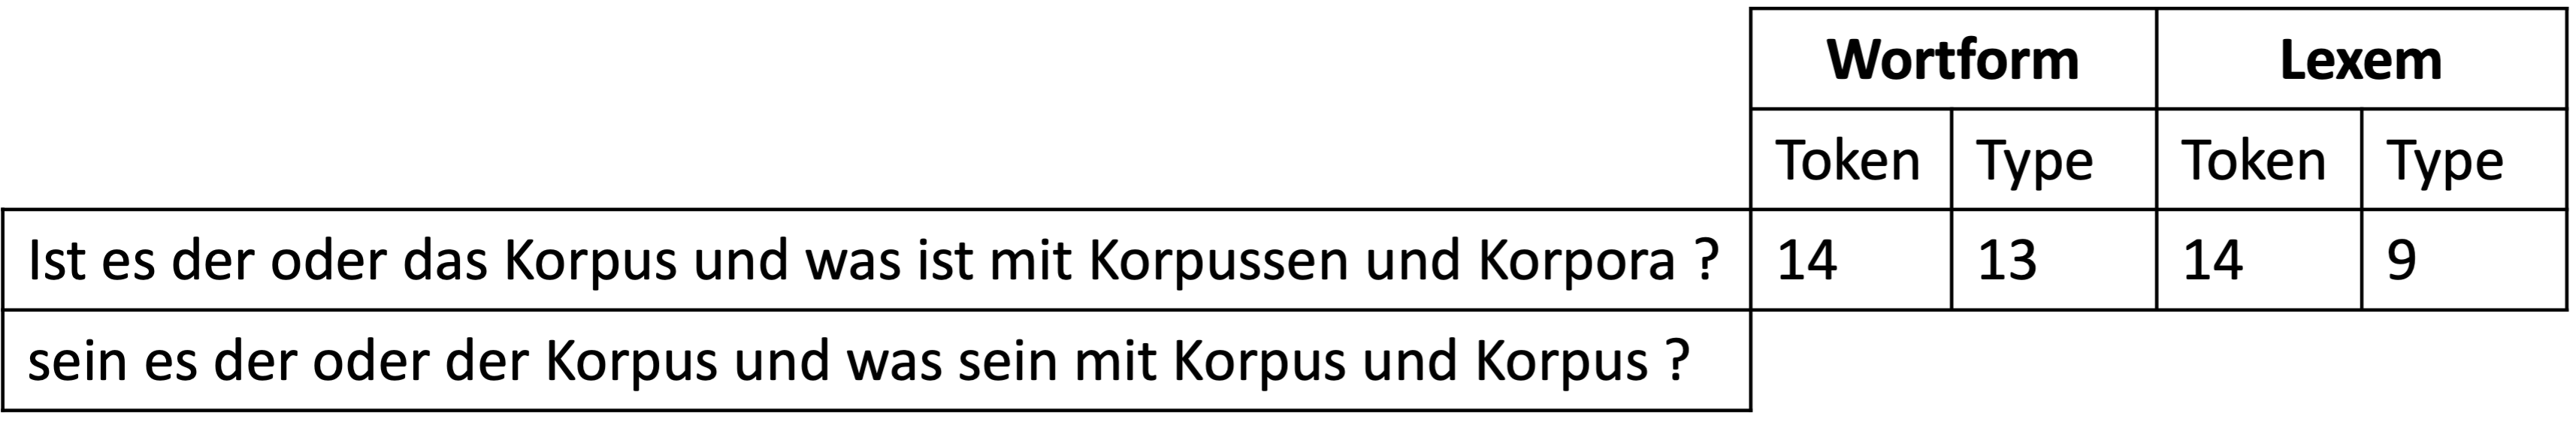

**2.** Wie nennt man das kleinste Form-Bedeutungs-Paar, d. h. die konkrete Realisierung einer Bedeutung?

**Antwort:**
Das nennt man Morph.


### d) Semantik & Pragmatik
**1.** Gegeben sind folgende Wortpaare:
1. Käse, Tilsiter
2. Moneten, Kröten
3. Lachs, Fisch

sowie folgende Relationen zwischen Konzepten:
- Synonymie
- Hypernymie
- Homophonie
- Hyponymie
- Homonymie

Geben Sie für jedes Wortpaar an, um welche Art von Relation es sich handelt. 

**Antwort**:
1. Hypernymie
2. Synonymie
3. Hyponymie

**2.** Was ist eine deiktische Referenz?

**Antwort:**
Es handelt sich um Referenzen mit Zeigegesten, welche nur in einem nicht-verbalen Kontext auftreten.